Data are imported with their URL path and the PANDA library has been used to make the array of data as a data structure.

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff                                
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import urllib.request
import seaborn as sns
import io

# hepatitis data load and convert to array
data_hepatitis = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data" , header=None)
data_hepatitis = data_hepatitis.to_numpy()

# diabeties load data and convert to array
url='https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff'
ddd=urllib.request.urlopen(url)
data, meta = arff.loadarff(io.StringIO(ddd.read().decode('utf-8')))
data_diabetes = pd.DataFrame(data)
data_diabetes = data_diabetes.to_numpy()

Class of cleaning has six methodologies to provide neat and trainable data for learning. This class can detect incomplete data and remove rows or columns which has the most missed data and then estimate the remaining missed data based on a KNN method and then find the best features with the highest coloration with target and least correlation together.

In [ ]:
class cleaning:

    def __init__(self,data):
        self.data=data
        return
    
    def type_data_miss (self,tp=1):
        self.tp=tp
        if tp==1:
            self.missing=np.equal(self.data,"?")
            
        elif tp==2:
            self.missing=np.equal(self.data[:,0],0)
            self.missing=np.transpose([np.transpose(self.missing)]*20)
        return self
    
    
    def column_clean(self,trsh=1):
        miss=[]
        for i in range(self.data.shape[1]):
            num_non=sum(self.missing[:,i])
            if num_non>trsh*self.data.shape[0]:
                miss.append(i)
        self.data=np.delete(self.data, miss, 1)
        self.missing=np.delete(self.missing, miss, 1)
        return self
    
    
    def row_clean(self,trsh=1):
        miss=[]
        for i in range(self.data.shape[0]):
            num_non=sum(self.missing[i,:])
            if num_non>trsh*self.data.shape[1]:
                miss.append(i)
        self.data=np.delete(self.data, miss, 0)
        self.missing=np.delete(self.missing, miss, 0)
        return self

    def data_derivation(self):
        perfect_data_rindex=[]
        incomplete_realdata_index=[]
        incomplete_predictdata_index=[]
        
        for i in range(self.data.shape[0]):
            num_non=sum(self.missing[i,:])
            if num_non==0:
                perfect_data_rindex.append(i)
            else:
                incomplete_realdata_index.append([])
                incomplete_predictdata_index.append([])
                for j in range(self.data.shape[1]):
                    if self.missing[i,j]:
                        incomplete_predictdata_index[len(incomplete_realdata_index)-1].append([i,j])
                    else:
                        incomplete_realdata_index[len(incomplete_realdata_index)-1].append([i,j])

        for i in range(len(incomplete_realdata_index)):
            dist_predict=[]
            for j in perfect_data_rindex:
                dist=0
                for k in range(len(incomplete_realdata_index[i])):
                    dist=dist+(float(self.data[j,incomplete_realdata_index[i][k][1]])-float(self.data[incomplete_realdata_index[i][k][0],incomplete_realdata_index[i][k][1]]))**2
                dist_predict.append(dist)
            m_list=min(dist_predict)
            ind=dist_predict.index(m_list)
            
            for l in range(len(incomplete_predictdata_index[i])):
                self.data[incomplete_predictdata_index[i][l][0],incomplete_predictdata_index[i][l][1]]=self.data[perfect_data_rindex[ind],incomplete_predictdata_index[i][l][1]]
        return self

    
    def best_correlation(self,num_f):
        variance=np.var(self.data.astype(float) , axis=0)
        columns=np.arange(self.data.shape[1])
        for i in range(0,len(variance)):
            if variance[i]==0:
                self.data=np.delete(self.data, columns[i], 1)
        data_df=pd.DataFrame(self.data).astype(float)
        data_correlation=data_df.corr(method='pearson').abs()
        if self.tp==1:
            clm=0
        else:
            clm=data_df.shape[1]-1
        target_correlation=data_correlation[clm]
        target_correlation=target_correlation.sort_values(ascending=False)
        data_indices=target_correlation.index
        cleaning_indices=[]
        cleaning_indices.append([data_indices[1],target_correlation[data_indices[1]]])
        
        for f in range(1,num_f):
            corr=0
            for i in range(len(cleaning_indices)+1,len(target_correlation)):
                c_test=1
                aa=target_correlation[data_indices[i]]
                for j in range(len(cleaning_indices)):
                    dc=data_correlation[data_indices[i]][cleaning_indices[j][0]]
                    c_test=c_test*(1-dc)
                c_test=c_test*aa
                if c_test>corr:
                    corr=c_test
                    ind=data_indices[i]
            cleaning_indices.append([ind,corr])
        df=pd.DataFrame(cleaning_indices)
        df=df.sort_values(by=[1])
        self.data=np.delete(self.data, df[0][0:data_indices.size-num_f], 1)
        return self
    
    def give_data(self):
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                self.data[i][j]=float(self.data[i][j])
        return self.data


Normalizing data to make all features equally important.

In [ ]:
def normalization( x_t):
    for i in range(x_t.shape[1]):
        max_f=max(x_t[:,i])
        x_t[:,i]=x_t[:,i]/max_f
    return x_t

Assign Data

In [ ]:
num_features_hpt=16                                                             # specifies number of features we want to have after cleaning data
hepatitis=cleaning(data_hepatitis)
data_hpt=hepatitis.type_data_miss(tp=1).column_clean(trsh=0.1).row_clean(trsh=0.1).data_derivation().give_data()

y_hpt, x_hpt = data_hpt[:,0].astype(int), data_hpt[:,1:num_features_hpt]
y_hpt=y_hpt-1
ind_p_hpt=np.where(y_hpt==1)
ind_n_hpt=np.where(y_hpt==0)
x_hpt=normalization(x_hpt)


# cleaning diabet data
num_features_dbt=19                                                             # specifies number of features we want to have after cleaning data
diabet=cleaning(data_diabetes)
data_dbt=diabet.type_data_miss(tp=2).row_clean(trsh=0.1).give_data()

# creating test and train set for diabetes
y_dbt, x_dbt = data_dbt[:,num_features_dbt-1].astype(int), data_dbt[:,0:num_features_dbt-1]
ind_p_dbt=np.where(y_dbt==1)
ind_n_dbt=np.where(y_dbt==0)
x_dbt=normalization(x_dbt)


x_dbt0=x_dbt[ind_n_dbt]
x_dbt1=x_dbt[ind_p_dbt]
x_hpt0=x_hpt[ind_n_hpt]
x_hpt1=x_hpt[ind_p_hpt]
x_hpt0=pd.DataFrame(x_hpt0)
x_hpt1=pd.DataFrame(x_hpt1)
x_dbt0=pd.DataFrame(x_dbt0)
x_dbt1=pd.DataFrame(x_dbt1)

Distribution of data in hepatitis

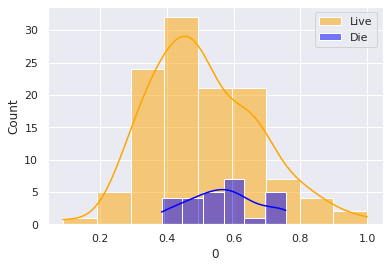

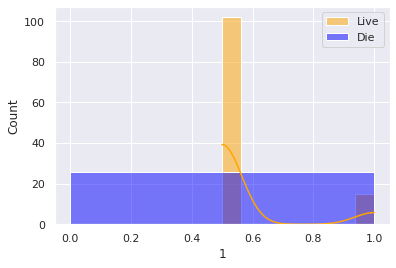

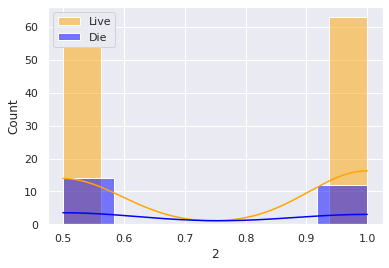

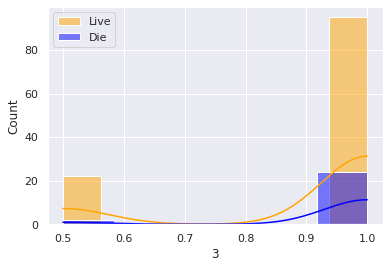

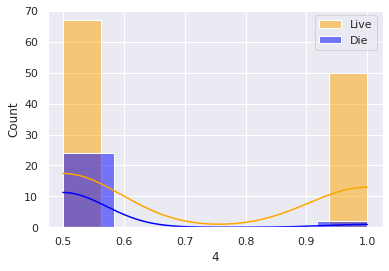

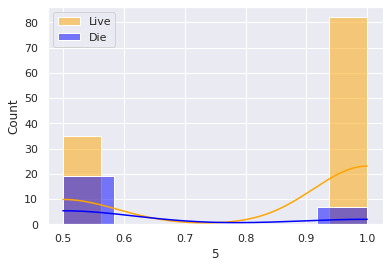

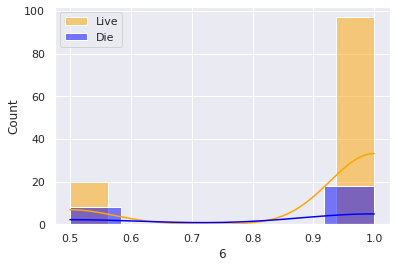

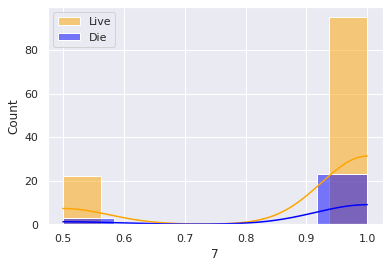

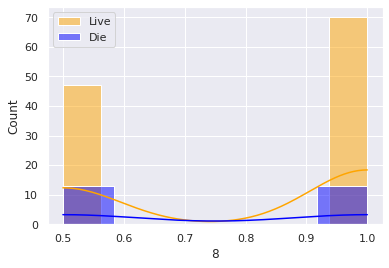

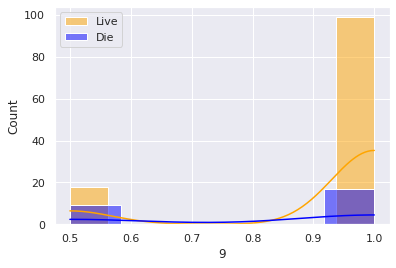

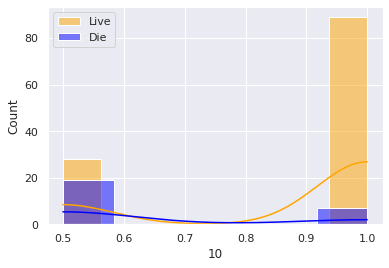

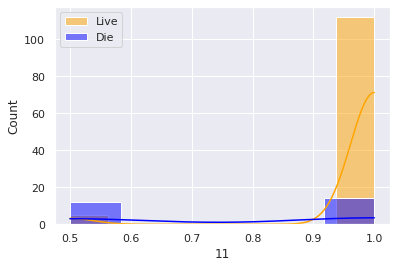

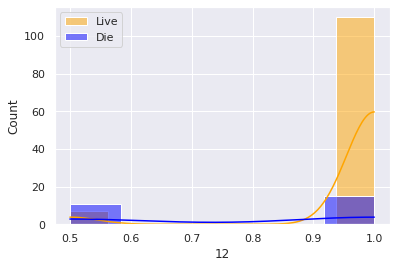

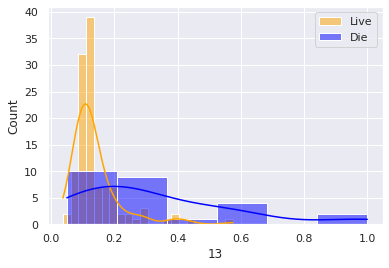

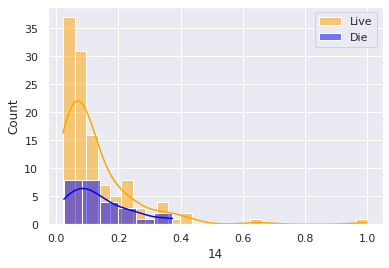

In [ ]:
sns.set(style="darkgrid")

for i in range(x_hpt.shape[1]):
  sns.histplot(data=x_hpt1, x=i, color="orange", label="Live", kde=True)
  sns.histplot(data=x_hpt0, x=i, color="blue", label="Die", kde=True)
  plt.legend() 
  plt.show()


Distribution of data in diabetes

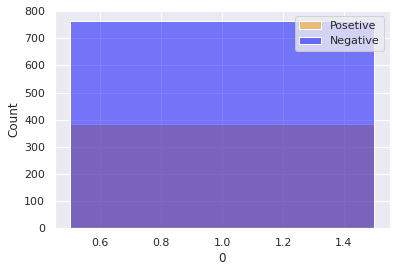

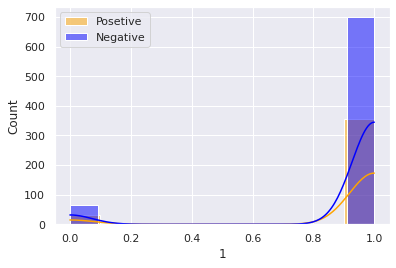

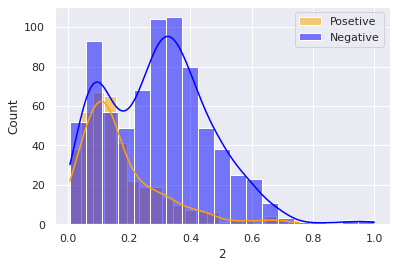

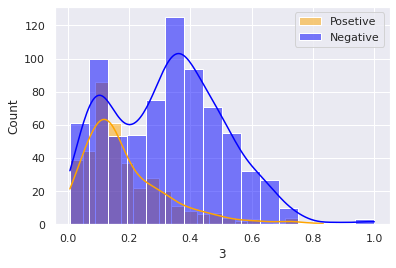

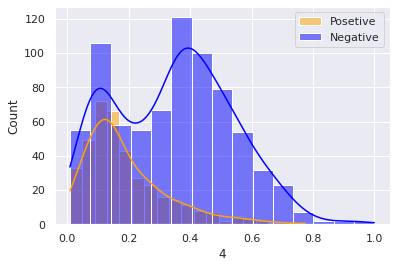

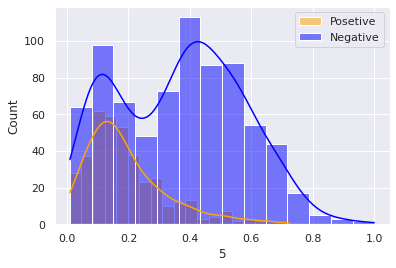

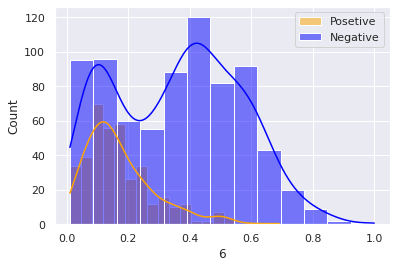

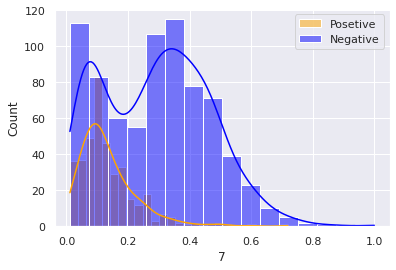

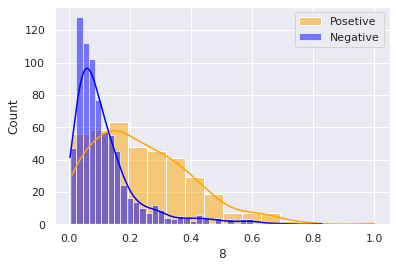

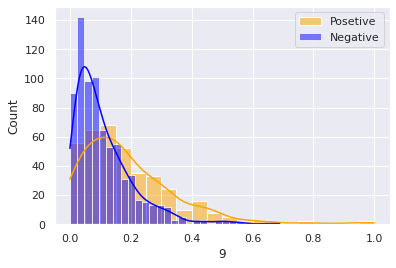

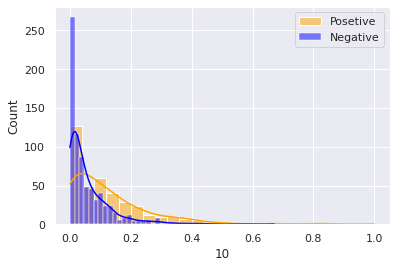

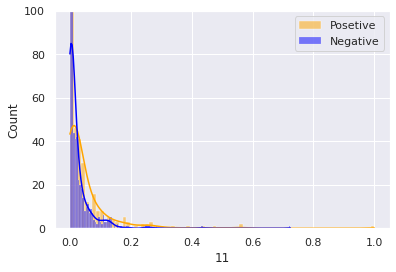

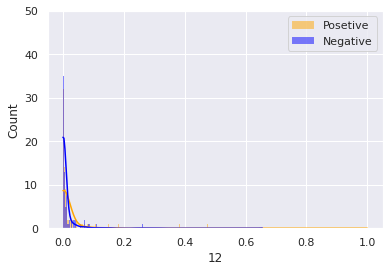

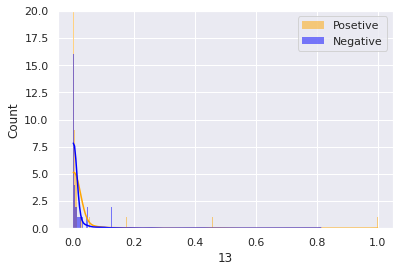

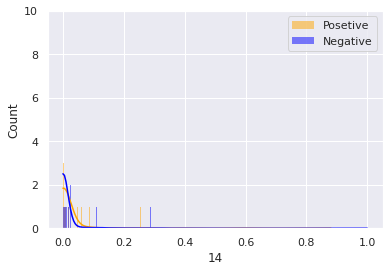

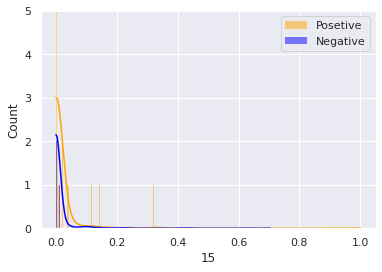

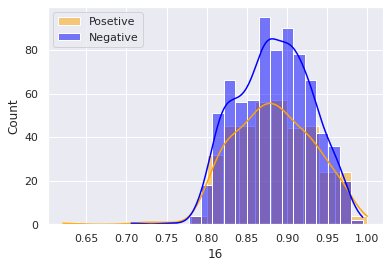

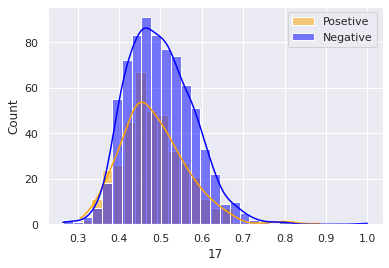

In [ ]:
for i in range(x_dbt.shape[1]):
  if i==11:
    fig, ax = plt.subplots()
    ax.set_ylim(0,100)
  if i==12:
    fig, ax = plt.subplots()
    ax.set_ylim(0,50)
  if i==13:
    fig, ax = plt.subplots()
    ax.set_ylim(0,20)
  if i==14:
    fig, ax = plt.subplots()
    ax.set_ylim(0,10)
  if i==15:
    fig, ax = plt.subplots()
    ax.set_ylim(0,5)
  sns.histplot(data=x_dbt1, x=i, color="orange", label="Posetive", kde=True)
  sns.histplot(data=x_dbt0, x=i, color="blue", label="Negative", kde=True)
  plt.legend() 
  plt.show()


In [ ]:
data_dbt=pd.DataFrame(data_dbt).astype(float)
data_hpt=pd.DataFrame(data_hpt).astype(float)
corr_hpt=data_hpt.corr(method='pearson')
corr_dbt=data_dbt.corr(method='pearson')

Correlation of features in hepatitis data

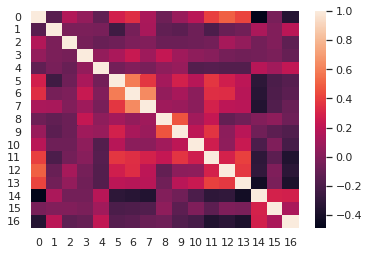

In [ ]:
p1 = sns.heatmap(corr_hpt)

Correlation of features in diabetes data

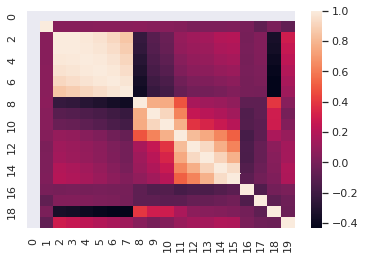

In [ ]:
p2 = sns.heatmap(corr_dbt)

In [ ]:
data_dbt=pd.DataFrame(data_dbt).astype(float)
data_hpt=pd.DataFrame(data_hpt).astype(float)
cov_hpt=data_hpt.cov()
cov_dbt=data_dbt.cov()

Covariance of features in hepatitis data

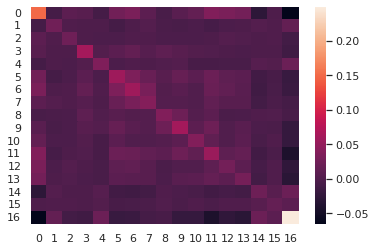

In [ ]:
p1 = sns.heatmap(cov_hpt)

Covariance of features in diabetes data

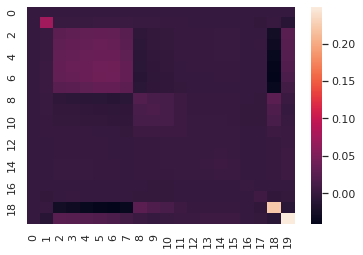

In [ ]:
p2 = sns.heatmap(cov_dbt)